# **Multi-label test classification using graph convoltution networks (GCN)**

Team members:


1.   ABHAY DA - PES1UG19CS011 (Section A)
2.   AKASH S - PES1UG19CS042 (Section A)

1.   PRIYA S S - PES1UG19CS404 (Section G)
2.   SEJAL MAURYA - PES1UG19CS440 (Section G)









# Dependencies

* Numpy
* Pandas
* Matplotlib
* Seaborn
* tqdm
* sklearn
* keybert
* pywsd
* wn (Version - 0.0.22)
* nltk
* keras
* torch
* scipy
* networkx


# Dataset Preparation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

In [2]:
import pandas as pd

In [3]:
df = pd.read_csv("bbc-data.csv", engine="python", error_bad_lines=False, usecols=['text', 'category'])

df.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


category                                               text
0  business  Ad sales boost Time Warner profit  Quarterly p...
1  business  Dollar gains on Greenspan speech  The dollar h...
2  business  Yukos unit buyer faces loan claim  The owners ...
3  business  High fuel prices hit BA's profits  British Air...
4  business  Pernod takeover talk lifts Domecq  Shares in U...

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['text'],df['category'], stratify=df['category'])

In [5]:
original_train_sentences = X_train.tolist()
original_labels_train = y_train.tolist()
original_test_sentences = X_test.tolist()
original_labels_test = y_test.tolist()

train_size = len(original_train_sentences)
test_size = len(original_test_sentences)
sentences = original_train_sentences + original_test_sentences

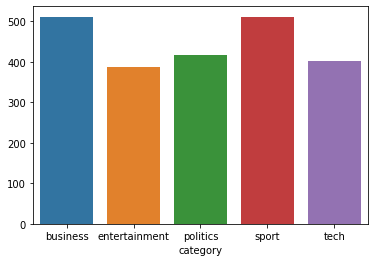

In [6]:
category_sizes = df.groupby('category').size()
sns.barplot(x=category_sizes.index, y= category_sizes)
plt.show()

# Hyper Parameters

In [7]:
EDGE = 1 
NODE = 0 
NUM_LAYERS = 2 

HIDDEN_DIM = 200
DROP_OUT = 0.5
LR = 0.02
WEIGHT_DECAY = 0
EARLY_STOPPING = 10
NUM_EPOCHS = 20

# Preprocess

## Label Encoding

In [8]:
import numpy as np
from sklearn.preprocessing import LabelEncoder

unique_labels=np.unique(original_labels_train)

num_class = len(unique_labels)
lEnc = LabelEncoder()
lEnc.fit(unique_labels)

print(unique_labels)
print(lEnc.transform(unique_labels))

train_labels = lEnc.transform(original_labels_train)
test_labels = lEnc.transform(original_labels_test)

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

labels = train_labels.tolist()+test_labels.tolist()
labels = torch.LongTensor(labels).to(device)

['business' 'entertainment' 'politics' 'sport' 'tech']
[0 1 2 3 4]


In [9]:
!pip install keybert
from keybert import KeyBERT

     |████████████████████████████████| 79 kB 4.0 MB/s 
     |████████████████████████████████| 232 kB 33.7 MB/s 
     |████████████████████████████████| 51 kB 6.7 MB/s 
     |████████████████████████████████| 4.0 MB 46.1 MB/s 
     |████████████████████████████████| 1.2 MB 41.6 MB/s 
     |████████████████████████████████| 77 kB 6.8 MB/s 
     |████████████████████████████████| 880 kB 41.8 MB/s 
     |████████████████████████████████| 6.6 MB 35.2 MB/s 
     |████████████████████████████████| 596 kB 45.9 MB/s 
  Created wheel for keybert: filename=keybert-0.5.1-py3-none-any.whl size=21332 sha256=bc2070055c59a41143c9347c5fe0dda2514aa9c08949762ae24d1e345cdc65d6
  Stored in directory: /root/.cache/pip/wheels/8e/95/c5/f5ceed2a9f9e80bc1a706a10a6fb03d726df7a3dd11800a58b
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.0-py3-none-any.whl size=120747 sha256=8ac0304bfba618332d9428bbf020831225b0f02a55396a8a5ae02ad6972d8ac8
  Stored in directory: /root/.cache/pip/whee

In [10]:
kw_model = KeyBERT(model='all-MiniLM-L6-v2')

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [11]:
def generate_keywords(text):
  keywords = kw_model.extract_keywords(text, 
      keyphrase_ngram_range=(1, 1), 
      stop_words='english', 
      highlight=False,
      top_n=10)
  keywords_list= list(dict(keywords).keys())
  return keywords_list

## Remove Stopwords and less frequent words, tokenize sentences

In [13]:
!pip install -U pywsd
!pip install -U wn==0.0.22

In [14]:
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [15]:
from nltk.corpus import stopwords
from keras.preprocessing.sequence import pad_sequences
import nltk
import re

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
remove_limit = 5


def clean_str(string):

    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    
    return string.strip().lower()

tokenize_sentences = []

original_word_freq = {}  
for sentence in tqdm(sentences):
    temp = clean_str(sentence)
    kwlist = generate_keywords(temp)
    tokenize_sentences.append(kwlist)
    for word in kwlist:
        if word in original_word_freq:
            original_word_freq[word] += 1
        else:
            original_word_freq[word] = 1   
print(tokenize_sentences)


word_list_dict = {}
idx = 0
for sentence in sentences:
    temp = clean_str(sentence)
    
    kwlist = tokenize_sentences[idx]
    idx += 1
    for word in kwlist: 
        word_list_dict[word] = 1
word_list = list(word_list_dict.keys())
vocab_length = len(word_list)

#word to id dict
word_id_map = {}
for i in range(vocab_length):
    word_id_map[word_list[i]] = i   
         
print(word_list)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


  0%|          | 0/2225 [00:00<?, ?it/s]

[['alicia', 'deaf', 'mccartney', 'audience', 'millions', 'cbs', 'super', 'bowl', 'tv', 'stadium'], ['ict', 'technology', 'technologies', 'businesses', 'firms', 'broadband', 'commerce', 'business', 'industrialised', 'internet'], ['nhs', 'inpatients', 'appointment', 'inpatient', 'patients', 'outpatient', 'waits', 'hospital', 'patient', 'wales'], ['blackpool', 'brighton', 'bournemouth', 'manchester', 'accommodation', 'seaside', 'parties', 'bookings', 'party', 'labour'], ['roxy', 'morrissey', 'band', 'tour', 'wight', 'supergrass', 'isle', 'avalon', 'lennon', 'street'], ['doping', 'olympic', 'olympics', 'conte', 'jones', 'ioc', 'medals', 'allegations', 'claims', 'indictment'], ['keane', 'rockers', 'bravery', 'rock', 'britpop', 'singer', 'pop', 'songs', 'rapper', 'pops'], ['ulster', 'borders', 'celtic', 'penalty', 'touchdown', 'penalties', 'scored', 'edged', 'scottish', 'irish'], ['oscar', 'awards', 'oscars', 'nominated', 'nominations', 'award', 'sideways', 'maria', 'actress', 'winners'], ['

In [16]:
node_size = train_size + vocab_length + test_size
node_size

8522

# Model Input

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm

## Generate Keywords

## word-word: PMI

In [18]:
from math import log
row = []
col = []
weight = []
window_size = 20
total_W = 0
word_occurrence = {}
word_pair_occurrence = {}

def ordered_word_pair(a, b):
    if a > b:
        return b, a
    else:
        return a, b

def update_word_and_word_pair_occurrence(q):
    unique_q = list(set(q))
    for i in unique_q:
        try:
            word_occurrence[i] += 1
        except:
            word_occurrence[i] = 1
    for i in range(len(unique_q)):
        for j in range(i+1, len(unique_q)):
            word1 = unique_q[i]
            word2 = unique_q[j]
            word1, word2 = ordered_word_pair(word1, word2)
            try:
                word_pair_occurrence[(word1, word2)] += 1
            except:
                word_pair_occurrence[(word1, word2)] = 1


for ind in tqdm(range(train_size+test_size)):
    words = tokenize_sentences[ind]
    
    q = []
    # push the first (window_size) words into a queue
    for i in range(min(window_size, len(words))):
        q += [word_id_map[words[i]]]
    # update the total number of the sliding windows
    total_W += 1
    # update the number of sliding windows that contain each word and word pair
    update_word_and_word_pair_occurrence(q)

    now_next_word_index = window_size
    # pop the first word out and let the next word in, keep doing this until the end of the document
    while now_next_word_index<len(words):
        q.pop(0)
        q += [word_id_map[words[now_next_word_index]]]
        now_next_word_index += 1
        # update the total number of the sliding windows
        total_W += 1
        # update the number of sliding windows that contain each word and word pair
        update_word_and_word_pair_occurrence(q)

for word_pair in word_pair_occurrence:
    i = word_pair[0]
    j = word_pair[1]
    count = word_pair_occurrence[word_pair]
    word_freq_i = word_occurrence[i]
    word_freq_j = word_occurrence[j]
    pmi = log((count * total_W) / (word_freq_i * word_freq_j))
    if pmi <=0:
        continue
    row.append(train_size + i)
    col.append(train_size + j)
    weight.append(pmi)
    row.append(train_size + j)
    col.append(train_size + i)
    weight.append(pmi)

  0%|          | 0/2225 [00:00<?, ?it/s]

## doc-word: Tf-idf

In [19]:
#get each word appears in which document
word_doc_list = {}
for word in word_list:
    word_doc_list[word]=[]

for i in range(len(tokenize_sentences)):
    doc_words = tokenize_sentences[i]
    unique_words = set(doc_words)
    for word in unique_words:
        exist_list = word_doc_list[word]
        exist_list.append(i)
        word_doc_list[word] = exist_list

#document frequency
word_doc_freq = {}
for word, doc_list in word_doc_list.items():
    word_doc_freq[word] = len(doc_list)

# term frequency
doc_word_freq = {}

for doc_id in range(len(tokenize_sentences)):
    words = tokenize_sentences[doc_id]
    for word in words:
        word_id = word_id_map[word]
        doc_word_str = str(doc_id) + ',' + str(word_id)
        if doc_word_str in doc_word_freq:
            doc_word_freq[doc_word_str] += 1
        else:
            doc_word_freq[doc_word_str] = 1

In [20]:
doc_nodes = set()
for i in range(len(tokenize_sentences)):
    words = tokenize_sentences[i]
    doc_word_set = set()
    for word in words:
        if word in doc_word_set:
            continue
        j = word_id_map[word]
        key = str(i) + ',' + str(j)
        freq = doc_word_freq[key]
        if i < train_size:
            row.append(i)
            doc_nodes.add(i)
        else:
            row.append(i + vocab_length)
            doc_nodes.add(i + vocab_length)
        col.append(train_size + j)
        idf = log(1.0 * len(tokenize_sentences) / word_doc_freq[word_list[j]])
        weight.append(freq * idf)
        doc_word_set.add(word)

## Adjacency matrix

In [21]:
import scipy.sparse as sp
adj = sp.csr_matrix((weight, (row, col)), shape=(node_size, node_size))

# build symmetric adjacency matrix
adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)

In [22]:
def normalize_adj(adj):
    """Symmetrically normalize adjacency matrix."""
    adj = sp.coo_matrix(adj)
    rowsum = np.array(adj.sum(1))
    d_inv_sqrt = np.power(rowsum, -0.5).flatten()
    d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
    d_mat_inv_sqrt = sp.diags(d_inv_sqrt)
    return adj.dot(d_mat_inv_sqrt).transpose().dot(d_mat_inv_sqrt).tocoo(), d_inv_sqrt
    
adj, norm_item = normalize_adj(adj + sp.eye(adj.shape[0]))


def sparse_mx_to_torch_sparse_tensor(sparse_mx):
    """Convert a scipy sparse matrix to a torch sparse tensor."""
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(
        np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse.FloatTensor(indices, values, shape).to(device)

adj = sparse_mx_to_torch_sparse_tensor(adj)

In [23]:
adj

tensor(indices=tensor([[   0, 1668, 1669,  ..., 7963, 7964, 8521],
                       [   0,    0,    0,  ..., 8521, 8521, 8521]]),
       values=tensor([0.0154, 0.0564, 0.0798,  ..., 0.1316, 0.1316, 0.0171]),
       device='cuda:0', size=(8522, 8522), nnz=197374, layout=torch.sparse_coo)

## Extracting edges for graph

In [24]:
node = adj._indices()

In [25]:
adj._values()

tensor([0.0154, 0.0564, 0.0798,  ..., 0.1316, 0.1316, 0.0171], device='cuda:0')

In [26]:
print(node[1].shape)

torch.Size([197374])


In [27]:
edge_list = []

for i, j in zip(node[0], node[1]):
  edge_list.append((i.item(), j.item() ))

## Networkx Graph of the nodes in dataset

In [28]:
import networkx as nx

In [29]:
G = nx.from_edgelist(edge_list)

In [30]:
for node in list(nx.connected_components(G))[-1]:
  G.remove_node(node)

In [31]:
import matplotlib.pyplot as plt

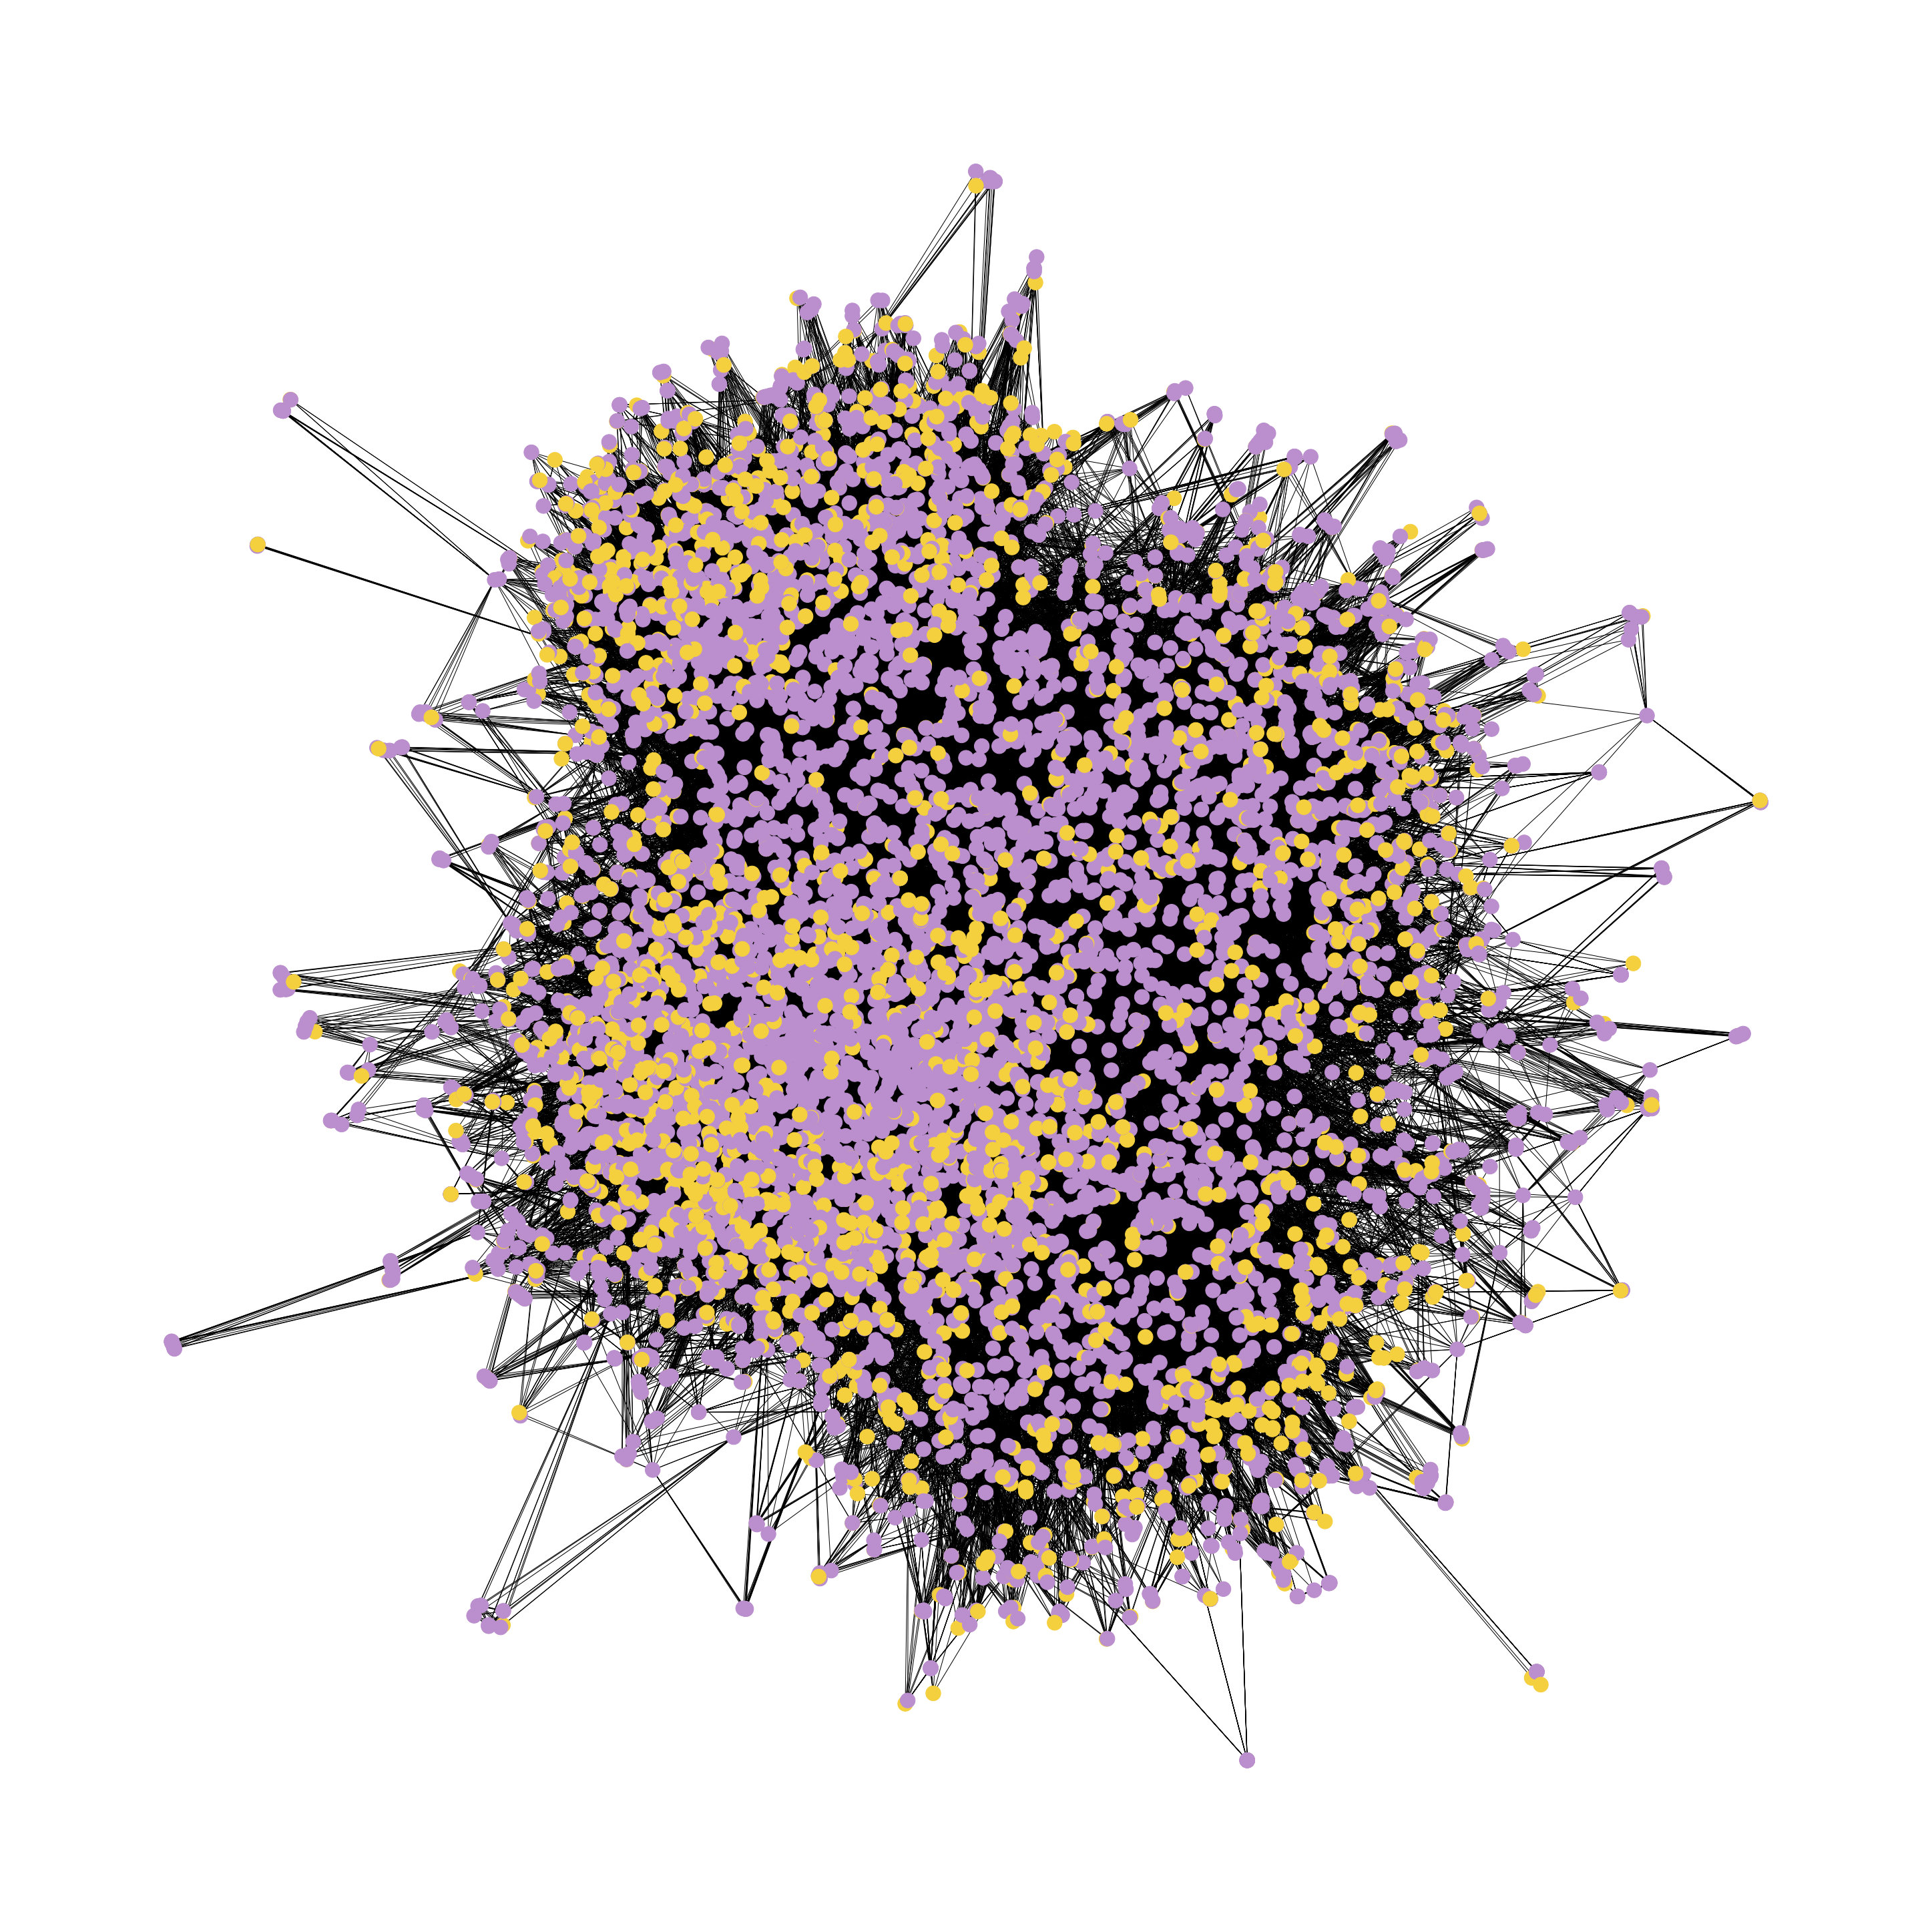

In [32]:
node_colors = ['#F4D03F' if node in doc_nodes else  '#BB8FCE' for node in G] 
G.remove_edges_from(nx.selfloop_edges(G))
G.remove_nodes_from(nx.isolates(G))
plt.figure(figsize=(40,40))
nx.draw(G, node_size=500, node_color=node_colors)
plt.show()

In [33]:
len(list(G.nodes))

8511

# Features

In [34]:
features = np.arange(node_size)
features = torch.FloatTensor(features).to(device)

In [35]:
features.shape

torch.Size([8522])

In [36]:
features

tensor([0.0000e+00, 1.0000e+00, 2.0000e+00,  ..., 8.5190e+03, 8.5200e+03,
        8.5210e+03], device='cuda:0')

# Model

## Graph convolution newtork (GCN) layer

In [37]:
import math

import torch

from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module


class GraphConvolution(Module):

    def __init__(self, in_features, out_features,  drop_out = 0, activation=None, bias=True):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.FloatTensor(in_features, out_features))
        if bias:
            self.bias = Parameter(torch.zeros(1, out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters(in_features, out_features)
        self.dropout = torch.nn.Dropout(drop_out)
        self.activation =  activation

    def reset_parameters(self,in_features, out_features):
        stdv = np.sqrt(6.0/(in_features+out_features))
        # stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)


    def forward(self, input, adj, feature_less = False):
        if feature_less:
            support = self.weight
            support = self.dropout(support)
        else:
            input = self.dropout(input)
            support = torch.mm(input, self.weight)
        output = torch.spmm(adj, support)
        if self.bias is not None:
            output = output + self.bias
        if self.activation is not None:
            output = self.activation(output)
        return output

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ')'

## Graph convolution newtork (GCN) model

In [38]:
import torch.nn as nn
import torch.nn.functional as F

class GCN(nn.Module):
    def __init__(self, nfeat, nhid, nclass, dropout, n_layers = 2):
        super(GCN, self).__init__()
        self.n_layers = n_layers
        self.gc_list = []
        if n_layers >= 2:
            self.gc1 = GraphConvolution(nfeat, nhid, dropout, activation = nn.ReLU())
            self.gc_list = nn.ModuleList([GraphConvolution(nhid, nhid, dropout, activation = nn.ReLU()) for _ in range(self.n_layers-2)])
            self.gcf = GraphConvolution(nhid, nclass, dropout)
        else:
            self.gc1 = GraphConvolution(nfeat, nclass, dropout)

    def forward(self, x, adj):
        if self.n_layers>=2:
            x = self.gc1(x, adj, feature_less = True)
            for i in range(self.n_layers-2):
                x = self.gc_list[i](x,adj)
            x = self.gcf(x,adj)
        else:
            x = self.gc1(x, adj, feature_less = True)
        return x

In [39]:
def cal_accuracy(predictions,labels):
    pred = torch.argmax(predictions,-1).cpu().tolist()
    lab = labels.cpu().tolist()
    cor = 0
    for i in range(len(pred)):
        if pred[i] == lab[i]:
            cor += 1
    return cor/len(pred)
    

# Training

## Intialize Model

In [40]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()

model = GCN(nfeat=node_size, nhid=HIDDEN_DIM, nclass=num_class, dropout=DROP_OUT,n_layers=NUM_LAYERS).to(device)
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

## Training and validating

In [41]:
def generate_train_val(train_pro=0.9):
    real_train_size = int(train_pro*train_size)
    val_size = train_size-real_train_size

    idx_train = np.random.choice(train_size, real_train_size,replace=False)
    idx_train.sort()
    idx_val = []
    pointer = 0
    for v in range(train_size):
        if pointer<len(idx_train) and idx_train[pointer] == v:
            pointer +=1
        else:
            idx_val.append(v)
    idx_test = range(train_size+vocab_length, node_size)
    return idx_train, idx_val, idx_test

idx_train, idx_val, idx_test = generate_train_val()

In [55]:
import time
val_acc = []
val_loss = []
loss_train = []
acc_train = []
epoch_list = []

def train_model(show_result = True):
    for epoch in range(NUM_EPOCHS):
        t = time.time()
        model.train()
        optimizer.zero_grad()
        output= model(features, adj)
        loss_training = criterion(output[idx_train], labels[idx_train])
        acc_training = cal_accuracy(output[idx_train], labels[idx_train])
        loss_training.backward()
        optimizer.step()

        model.eval()
        output = model(features, adj)
        loss_val = criterion(output[idx_val], labels[idx_val])
        
        acc_val = cal_accuracy(output[idx_val], labels[idx_val])
        
        epoch_list.append(epoch + 1)
        loss_train.append(loss_training.item())
        val_loss.append(loss_val.item())
        acc_train.append(acc_training)
        val_acc.append(acc_val)

        if show_result:
            print(  'Epoch: {:04d}'.format(epoch+1),
                    'loss_train: {:.4f}'.format(loss_training.item()),
                    'acc_train: {:.4f}'.format(acc_training),
                    'loss_val: {:.4f}'.format(loss_val.item()),
                    'acc_val: {:.4f}'.format(acc_val),
                    'time: {:.4f}s'.format(time.time() - t))

train_model()

Epoch: 0001 loss_train: 0.0061 acc_train: 0.9980 loss_val: 0.5826 acc_val: 0.8862 time: 0.0350s
Epoch: 0002 loss_train: 0.0071 acc_train: 0.9987 loss_val: 0.5872 acc_val: 0.8862 time: 0.0363s
Epoch: 0003 loss_train: 0.0063 acc_train: 0.9987 loss_val: 0.5921 acc_val: 0.8862 time: 0.0364s
Epoch: 0004 loss_train: 0.0053 acc_train: 0.9987 loss_val: 0.5971 acc_val: 0.8862 time: 0.0344s
Epoch: 0005 loss_train: 0.0053 acc_train: 0.9987 loss_val: 0.6012 acc_val: 0.8862 time: 0.0359s
Epoch: 0006 loss_train: 0.0053 acc_train: 0.9980 loss_val: 0.6054 acc_val: 0.8862 time: 0.0348s
Epoch: 0007 loss_train: 0.0047 acc_train: 0.9987 loss_val: 0.6097 acc_val: 0.8862 time: 0.0344s
Epoch: 0008 loss_train: 0.0046 acc_train: 0.9987 loss_val: 0.6140 acc_val: 0.8922 time: 0.0343s
Epoch: 0009 loss_train: 0.0041 acc_train: 0.9987 loss_val: 0.6184 acc_val: 0.8922 time: 0.0330s
Epoch: 0010 loss_train: 0.0049 acc_train: 0.9987 loss_val: 0.6225 acc_val: 0.8922 time: 0.0332s
Epoch: 0011 loss_train: 0.0035 acc_train

## Evaluation

In [56]:
predictions = []
from sklearn.metrics import f1_score, accuracy_score
def test():
    model.eval()
    output = model(features, adj)
    global predictions
    predictions = torch.argmax(output[idx_test],-1).cpu().tolist()
    acc = accuracy_score(test_labels,predictions)
    f11 = f1_score(test_labels,predictions, average='macro')
    f12 = f1_score(test_labels,predictions, average = 'weighted')
    return acc, f11, f12

acc, f11, f12 = test()
print("Accuracy:",np.round(acc, 4))
print("Macro F1:",np.round(f11, 4))
print("Weighted F1:",np.round(f12, 4))

Accuracy: 0.9318
Macro F1: 0.9295
Weighted F1: 0.9318


# Plots

In [45]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(test_labels, predictions)
cm.shape

(5, 5)

Text(33.0, 0.5, 'Truth')

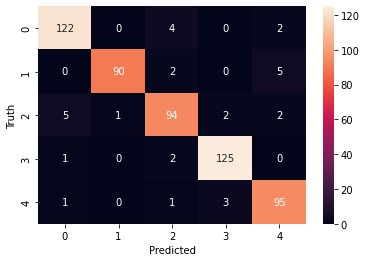

In [46]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

No handles with labels found to put in legend.


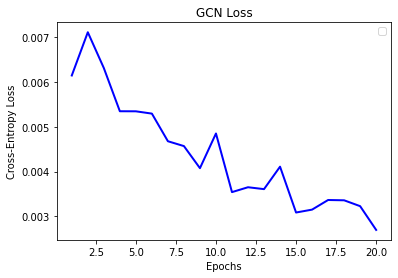

In [63]:
#generate plots
plt.figure()
plt.plot(epoch_list, loss_train, lw=2.0, color='b')
plt.title('GCN Loss')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend(loc='upper right')
plt.show()